In [10]:
import climlab
import matplotlib.pyplot as plt

Opened data from /opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.
[0.03631771]


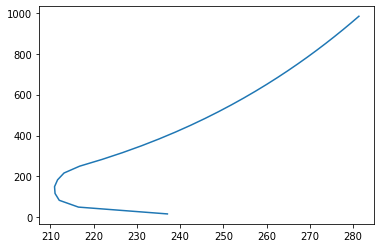